# 저수준 선형 분류 신경망

순수 텐서플로우 API만을 이용하여 두 개의 층을 갖는 선형 분류 신경망을 구현하라.

In [1]:
import tensorflow as tf
import numpy as np

## 데이터셋 생성

- `np.random.multivariate_normal()`
    - 다변량 정규분포를 따르는 데이터 생성
    - 평균값과 공분산 지정 필요
- 음성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[0, 3]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`
- 양성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[3, 0]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`

In [2]:
num_samples_per_class = 1000

# 음성 데이터셋
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

# 양성 데이터셋
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

두 개의 `(1000, 2)` 모양의 양성, 음성 데이터셋을 하나의 `(2000, 2)` 모양의 데이터셋으로 합치면서
동시에 자료형을 `np.float32`로 지정한다. 
자료형을 지정하지 않으면 `np.float64`로 지정되어 보다 많은 메모리와 실행시간을 요구한다.

In [3]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

음성 샘플의 타깃은 0, 양성 샘플의 타깃은 1로 지정한다.

In [4]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

양성, 음성 샘플을 색깔로 구분하면 다음과 같다.

- `inputs[:, 0]`: x 좌표
- `inputs[:, 1]`: x 좌표
- `c=targets[:, 0]`: 0 또는 1에 따른 색상 지정

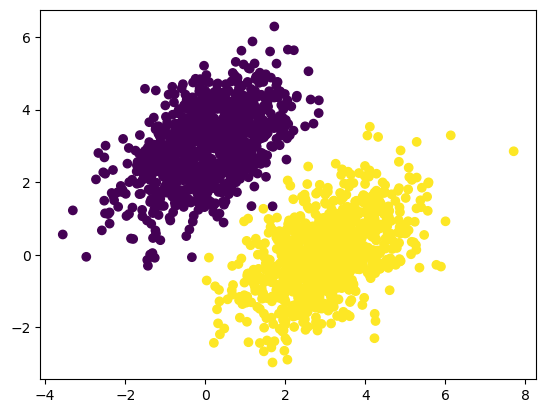

In [5]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

## 가중치 변수 텐서 생성

In [6]:
inter_layers_dim1 = 5

In [7]:
input_dim1 = 2                     # 입력 샘플의 특성수
output_dim1 = inter_layers_dim1    # 출력 샘플의 특성수

# 가중치: 무작위 초기화
W1 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim1, output_dim1)))

# 편향: 0으로 초기화
b1 = tf.Variable(initial_value=tf.zeros(shape=(output_dim1,)))

In [8]:
input_dim2 = inter_layers_dim1     # 입력 샘플의 특성수
output_dim2 = 1                    # 하나의 값으로 출력

# 가중치: 무작위 초기화
W2 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim2, output_dim2)))

# 편향: 0으로 초기화
b2 = tf.Variable(initial_value=tf.zeros(shape=(output_dim2,)))

## 예측 모델(함수) 선언

아래 함수는 하나의 층을 사용하는 모델의 출력값을 계산하는 과정이다.

In [9]:
def layer1(inputs, activation=None):
    outputs = tf.matmul(inputs, W1) + b1
    if activation != None:
        return activation(outputs)
    else:
        return outputs

In [10]:
def layer2(inputs, activation=None):
    outputs = tf.matmul(inputs, W2) + b2
    if activation != None:
        return activation(outputs)
    else:
        return outputs

In [11]:
def model(inputs):
    layer1_outputs = layer1(inputs, tf.nn.relu)
    layer2_outputs = layer2(layer1_outputs)
    return layer2_outputs

## 손실 함수: 평균 제곱 오차(MSE)


- `tf.reduce_mean()`: 텐서에 포함된 항목들의 평균값 계산.
    넘파이의 `np.mean()`과 결과는 동일하지만 텐서플로우의 텐서를 대상으로 함.

In [12]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

## 훈련 단계


하나의 배치에 대해 예측값을 계산한 후에 손실 함수의 그레이디언트를 이용하여 가중치와 편향을 업데이트한다. 

In [13]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W1, grad_loss_wrt_b1, grad_loss_wrt_W2, grad_loss_wrt_b2 = tape.gradient(loss, [W1, b1, W2, b2])
    W1.assign_sub(grad_loss_wrt_W1 * learning_rate)
    b1.assign_sub(grad_loss_wrt_b1 * learning_rate)
    W2.assign_sub(grad_loss_wrt_W2 * learning_rate)
    b2.assign_sub(grad_loss_wrt_b2 * learning_rate)
    return loss

## 배치 훈련

배치 훈련을 총 100번 반복한다.

In [14]:
for step in range(100):
    loss = training_step(inputs, targets)
    if step % 10 == 0:
        print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 8.0635
Loss at step 10: 0.2516
Loss at step 20: 0.2500
Loss at step 30: 0.2498
Loss at step 40: 0.2496
Loss at step 50: 0.2494
Loss at step 60: 0.2492
Loss at step 70: 0.2490
Loss at step 80: 0.2488
Loss at step 90: 0.2486


훈련을 보다 더 해볼 수도 있어 보인다. 
600번 정도 더 훈련하면 손실값이 정체하기 시작한다. 

In [15]:
for step in range(1000):
    loss = training_step(inputs, targets)
    if step % 100 == 0:
        print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.2483
Loss at step 100: 0.2388
Loss at step 200: 0.0462
Loss at step 300: 0.0345
Loss at step 400: 0.0312
Loss at step 500: 0.0286
Loss at step 600: 0.0263
Loss at step 700: 0.0243
Loss at step 800: 0.0225
Loss at step 900: 0.0211


## 예측

In [16]:
predictions = model(inputs)

예측 결과를 확인하면 다음과 같다.
예측값이 0.5보다 클 때 양성으로 판정한다.

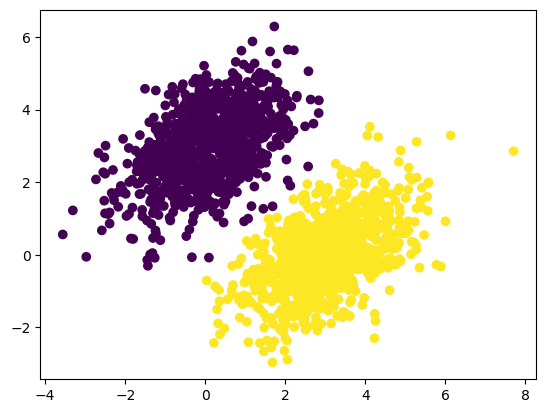

In [17]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()